In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize = (14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')
import os
import sys
sys.path.append(os.path.abspath('../'))
import abupy
from abupy import six, xrange
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

only use pandas calc nd, please install talib!
enable example env will only read RomDataBu/df_kl.h5


# 第6章 量化工具-数学

## 6.1 回归与插值

### 6.1.1 线性回归

In [2]:
from abupy import ABuSymbolPd
tsla_close = ABuSymbolPd.make_kl_df('usTSLA').close
# x序列: 0，1，2, ...len(tsla_close)
x = np.arange(0, tsla_close.shape[0])
# 收盘价格序列
y = tsla_close.values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     40.91
Date:                Fri, 05 May 2017   Prob (F-statistic):           3.66e-10
Time:                        21:52:41   Log-Likelihood:                -2327.1
No. Observations:                 504   AIC:                             4658.
Df Residuals:                     502   BIC:                             4667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        240.5507      2.183    110.197      0.000       236.262   244.840
x1            -0.0481      0.008     -6.396      0.000        -0.063    -0.033
==============================================================================
Omnibus:                       10.010   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.243
Skew:                          -0.332   Prob(JB):                      0.00597
Kurtosis:                       2.783   Cond. No.                         580.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

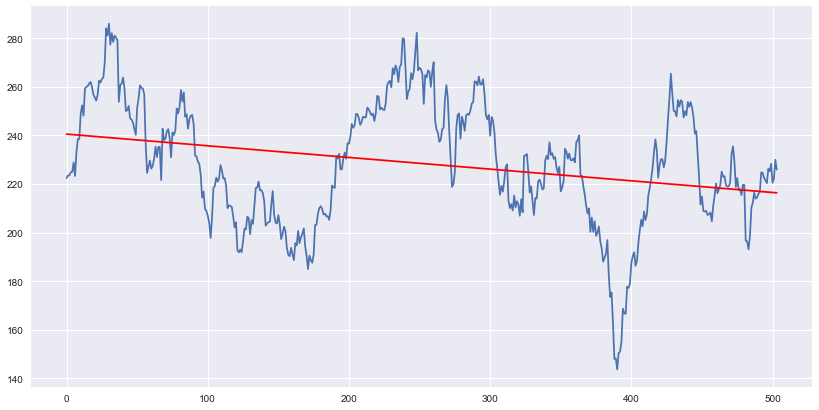

In [3]:
import statsmodels.api as sm
from statsmodels import regression


def regress_y(y):
    y = y
    # x序列: 0，1，2, ...len(y)
    x = np.arange(0, len(y))
    x = sm.add_constant(x)
    # 使用OLS做拟合
    model = regression.linear_model.OLS(y, x).fit()
    return model


model = regress_y(y)
b = model.params[0]
k = model.params[1]
# y = kx + b
y_fit = k * x + b
plt.plot(x, y)
plt.plot(x, y_fit, 'r')
# summary模型拟合概述，表6-1所示
model.summary()

In [4]:
MAE = sum(np.abs(y - y_fit)) / len(y)
print('偏差绝对值之和(MAE)={}'.format(MAE))

偏差绝对值之和(MAE)=19.948837366201527


In [5]:
MSE = sum(np.square(y - y_fit)) / len(y)
print('偏差绝对值之和(MSE)={}'.format(MSE))

偏差绝对值之和(MSE)=599.8086688451215


In [6]:
RMSE = np.sqrt(sum(np.square(y - y_fit)) / len(y))
print('偏差绝对值之和(RMSE)={}'.format(RMSE)) 

偏差绝对值之和(RMSE)=24.490991585583494


In [7]:
from sklearn import metrics

print('sklearn偏差绝对值之和(MAE)={}'.format(metrics.mean_absolute_error(y, y_fit))) 
print('sklearn偏差平方(MSE)={}'.format(metrics.mean_squared_error(y, y_fit)))
print('sklearn偏差平方和开平方(RMSE)={}'.format(np.sqrt(metrics.mean_squared_error(y, y_fit))))

sklearn偏差绝对值之和(MAE)=19.94883736620153
sklearn偏差平方(MSE)=599.8086688451214
sklearn偏差平方和开平方(RMSE)=24.49099158558349


### 6.1.2 多项式回归

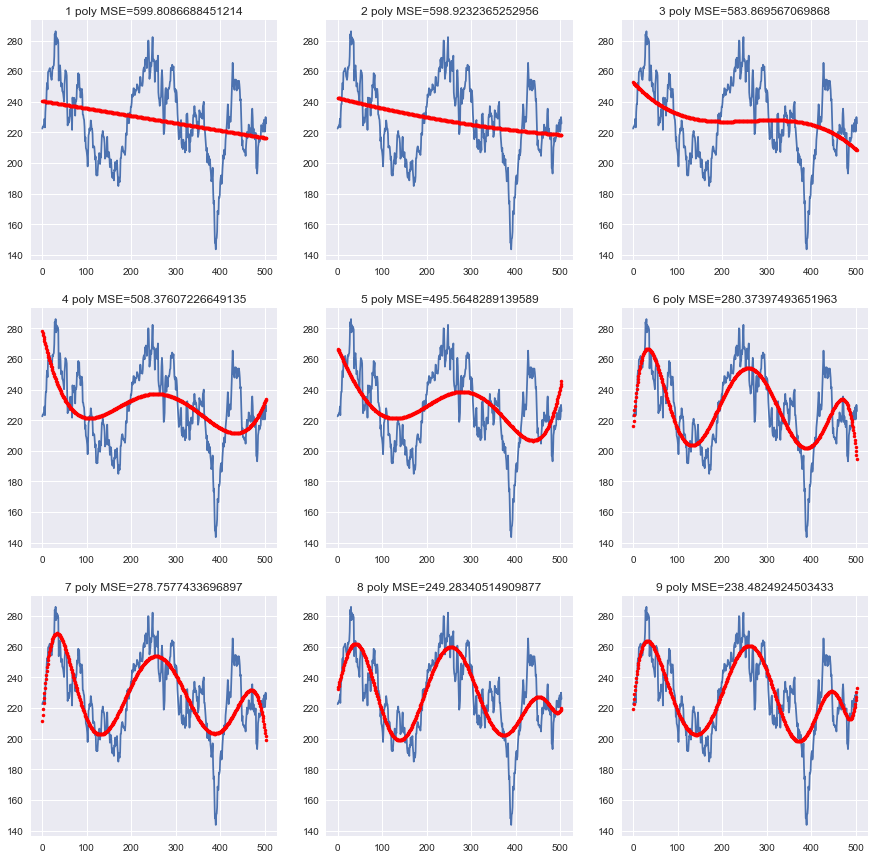

In [8]:
import itertools

# 生成9个subplots 3*3
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# 将 3 * 3转换成一个线性list
axs_list = list(itertools.chain.from_iterable(axs))
# 1-9次多项式回归
poly = np.arange(1, 10, 1)
for p_cnt, ax in zip(poly, axs_list):
    # 使用polynomial.Chebyshev.fit进行多项式拟合
    p = np.polynomial.Chebyshev.fit(x, y, p_cnt)
    # 使用p直接对x序列代人即得到拟合结果序列
    y_fit = p(x)
    # 度量mse值
    mse = metrics.mean_squared_error(y, y_fit)
    # 使用拟合次数和mse误差大小设置标题
    ax.set_title('{} poly MSE={}'.format(p_cnt, mse))
    ax.plot(x, y, '', x, y_fit, 'r.')

### 6.1.3 插值

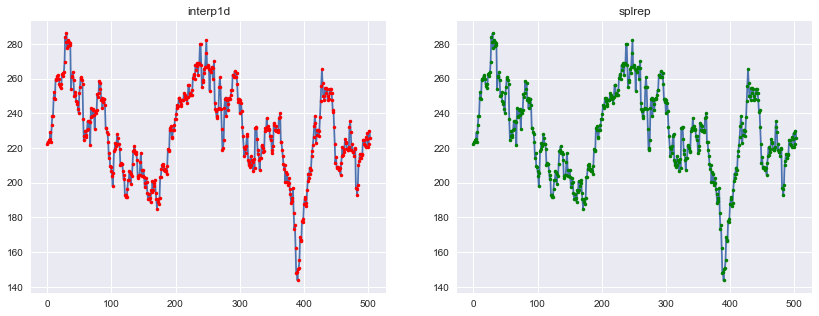

In [10]:
from scipy.interpolate import interp1d, splrep, splev

# 示例两种插值计算方式
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# 线性插值
linear_interp = interp1d(x, y)
# axs[0]左边的
axs[0].set_title('interp1d')
# 在相同坐标系下，同样的x，插值的y值使r.绘制（红色点）
axs[0].plot(x, y, '', x, linear_interp(x), 'r.')

# B-spline插值
splrep_interp = splrep(x, y)
# axs[1]右边的
axs[1].set_title('splrep')
# #在相同坐标系下，同样的x，插值的y值使g.绘制（绿色点）
axs[1].plot(x, y, '', x, splev(x, splrep_interp), 'g.');

## 6.2 蒙特卡洛方法与凸优化

### 6.2.1 你一生的追求到底能带来多少幸福

In [3]:
from abc import ABCMeta, abstractmethod

# 每个人平均寿命期望是75年，约75*365=27375天
K_INIT_LIVING_DAYS = 27375

class Person(object):
    """
        人类
    """

    def __init__(self):
        # 初始化人平均能活的寿命
        self.living = K_INIT_LIVING_DAYS
        # 初始化幸福指数
        self.happiness = 0
        # 初始化财富值
        self.wealth = 0
        # 初始化名望权利
        self.fame = 0
        # 活着的第几天
        self.living_day = 0

    def live_one_day(self, seek):
        """
        每天只能进行一个seek，这个seek决定了你今天追求的是什么，得到了什么
        seek的类型属于下面将编写的BaseSeekDay
        :param seek:
        :return:
        """
        # 调用每个独特的BaseSeekDay类都会实现的do_seek_day，得到今天的收获
        consume_living, happiness, wealth, fame = seek.do_seek_day()
        # 每天要减去生命消耗，有些seek前面还会增加生命
        self.living -= consume_living
        # seek得到的幸福指数积累
        self.happiness += happiness
        # seek得到的财富积累
        self.wealth += wealth
        # seek得到的名望权力积累
        self.fame += fame
        # 活完这一天了
        self.living_day += 1

In [4]:
class BaseSeekDay(six.with_metaclass(ABCMeta, object)):
    def __init__(self):
        # 每个追求每天消耗生命的常数
        self.living_consume = 0

        # 每个追求每天幸福指数常数
        self.happiness_base = 0

        # 每个追求每天财富积累常数
        self.wealth_base = 0
        # 每个追求每天名望权利积累常数
        self.fame_base = 0

        # 每个追求每天消耗生命的可变因素序列
        self.living_factor = [0]

        # 每个追求每天幸福指数的可变因素序列
        self.happiness_factor = [0]

        # 每个追求每天财富积累的可变因素序列
        self.wealth_factor = [0]
        # 每个追求每天名望权利的可变因素序列
        self.fame_factor = [0]

        # 追求了多少天了这一生
        self.do_seek_day_cnt = 0
        # 子类进行常数及可变因素序列设置
        self._init_self()

    @abstractmethod
    def _init_self(self, *args, **kwargs):
        # 子类必须实现，设置自己的生命消耗的常数，幸福指数常数等常数设置
        pass

    @abstractmethod
    def _gen_living_days(self, *args, **kwargs):
        # 子类必须实现，设置自己的可变因素序列
        pass

    def do_seek_day(self):
        """
        每一天的追求具体seek
        :return:
        """
        # 生命消耗=living_consume:消耗常数 * happiness_factor:可变序列
        if self.do_seek_day_cnt >= len(self.living_factor):
            # 超出len(self.living_factor), 就取最后一个living_factor[-1]
            consume_living = \
                self.living_factor[-1] * self.living_consume
        else:
            # 每个类自定义这个追求的消耗生命常数，以及living_factor，比如
            # HealthSeekDay追求健康，living_factor序列的值即由负值->正值
            # 每个子类living_factor会有自己特点的变化速度及序列长度，导致每个
            # 追求对生命的消耗随着追求的次数变化不一
            consume_living = self.living_factor[self.do_seek_day_cnt] \
                             * self.living_consume
        # 幸福指数=happiness_base:幸福常数 * happiness_factor:可变序列
        if self.do_seek_day_cnt >= len(self.happiness_factor):
            # 超出len(self.happiness_factor), 就取最后一个
            # 由于happiness_factor值由:n—>0 所以happiness_factor[-1]=0
            # 即随着追求一个事物的次数过多后会变的没有幸福感
            happiness = self.happiness_factor[
                            -1] * self.happiness_base
        else:
            # 每个类自定义这个追求的幸福指数常数，以及happiness_factor
            # happiness_factor子类的定义一般是从高－>低变化
            happiness = self.happiness_factor[
                            self.do_seek_day_cnt] * self.happiness_base
        # 财富积累=wealth_base:积累常数 * wealth_factor:可变序列
        if self.do_seek_day_cnt >= len(self.wealth_factor):
            # 超出len(self.wealth_factor), 就取最后一个
            wealth = self.wealth_factor[-1] * self.wealth_base
        else:
            # 每个类自定义这个追求的财富指数常数，以及wealth_factor
            wealth = self.wealth_factor[
                         self.do_seek_day_cnt] * self.wealth_base
        # 权利积累=fame_base:积累常数 * fame_factor:可变序列
        if self.do_seek_day_cnt >= len(self.fame_factor):
            # 超出len(self.fame_factor), 就取最后一个
            fame = self.fame_factor[-1] * self.fame_base
        else:
            # 每个类自定义这个追求的名望权利指数常数，以及fame_factor
            fame = self.fame_factor[
                       self.do_seek_day_cnt] * self.fame_base
        # 追求了多少天了这一生 + 1
        self.do_seek_day_cnt += 1
        # 返回这个追求这一天对生命的消耗，得到的幸福，财富，名望权利
        return consume_living, happiness, wealth, fame

In [5]:
def regular_mm(group):
    # 最小-最大规范化
    return (group - group.min()) / (group.max() - group.min())


class HealthSeekDay(BaseSeekDay):
    """
        HealthSeekDay追求健康长寿的一天:
        形象：健身，旅游，娱乐，做感兴趣的事情。
        抽象：追求健康长寿。
    """

    def _init_self(self):
        # 每天对生命消耗的常数＝1，即代表1天
        self.living_consume = 1
        # 每天幸福指数常数＝1
        self.happiness_base = 1
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成12000个序列，因为下面的happiness_factor序列值由1－>0
        # 所以大于12000次的追求都将只是单纯消耗生命，并不增加幸福指数
        # 即随着做一件事情的次数越来越多，幸福感越来越低，直到完全体会不到幸福
        days = np.arange(1, 12000)
        # 基础函数选用sqrt, 影响序列变化速度
        living_days = np.sqrt(days)

        """
            对生命消耗可变因素序列值由-1->1, 也就是这个追求一开始的时候对生命
            的消耗为负增长，延长了生命，随着追求的次数不断增多对生命的消耗转为正
            数因为即使一个人天天锻炼身体，天天吃营养品，也还是会有自然死亡的那
            一天
        """
        # *2-1的目的:regular_mm在0-1之间,HealthSeekDay要结果在－1，1之间
        self.living_factor = regular_mm(living_days) * 2 - 1
        # 结果在1-0之间 [::-1]: 将0->1转换到1->0
        self.happiness_factor = regular_mm(days)[::-1]

In [16]:
# 初始化我, 你一生的故事：HealthSeekDay
me = Person()
# 初始化追求健康长寿快乐
seek_health = HealthSeekDay()
while me.living > 0:
    # 只要还活着，就追求健康长寿快乐
    me.live_one_day(seek_health)

print('只追求健康长寿快乐活了{}年，幸福指数{},积累财富{},名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

只追求健康长寿快乐活了97.12年，幸福指数5999.5,积累财富0,名望权力0


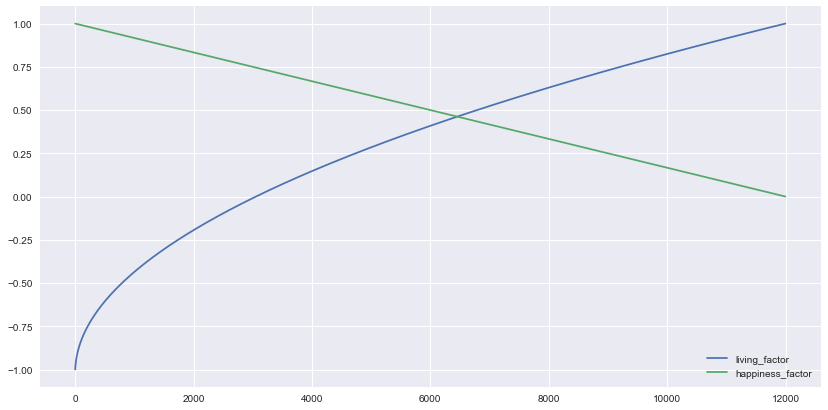

In [17]:
plt.plot(seek_health.living_factor * seek_health.living_consume)
plt.plot(seek_health.happiness_factor * seek_health.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')

In [6]:
class StockSeekDay(BaseSeekDay):
    """
        StockSeekDay追求财富金钱的一天:
        形象：做股票投资赚钱的事情。
        抽象：追求财富金钱
    """

    def _init_self(self, show=False):
        # 每天对生命消耗的常数＝2，即代表2天
        self.living_consume = 2
        # 每天幸福指数常数＝0.5
        self.happiness_base = 0.5
        # 财富积累常数＝10，默认＝0
        self.wealth_base = 10
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成10000个序列
        days = np.arange(1, 10000)
        # 针对生命消耗living_factor的基础函数还是sqrt
        living_days = np.sqrt(days)
        # 由于不需要像HealthSeekDay从负数开始，所以直接regular_mm 即:0->1
        self.living_factor = regular_mm(living_days)
        
        # 针对幸福感可变序列使用了np.power4，即变化速度比sqrt快
        happiness_days = np.power(days, 4)
        # 幸福指数可变因素会快速递减由1->0
        self.happiness_factor = regular_mm(happiness_days)[::-1]
        
        """
            这里简单设定wealth_factor=living_factor
            living_factor(0-1), 导致wealth_factor(0-1), 即财富积累越到
            后面越有效率，速度越快，头一个100万最难赚
        """
        self.wealth_factor = self.living_factor

In [19]:
# 初始化我, 你一生的故事：StockSeekDay
me = Person()
# 初始化追求财富金钱
seek_stock = StockSeekDay()
while me.living > 0:
    # 只要还活着，就追求财富金钱
    me.live_one_day(seek_stock)

print('只追求财富金钱活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       round(me.wealth, 2), me.fame))

只追求财富金钱活了46.72年，幸福指数1000.15, 积累财富136878.35, 名望权力0


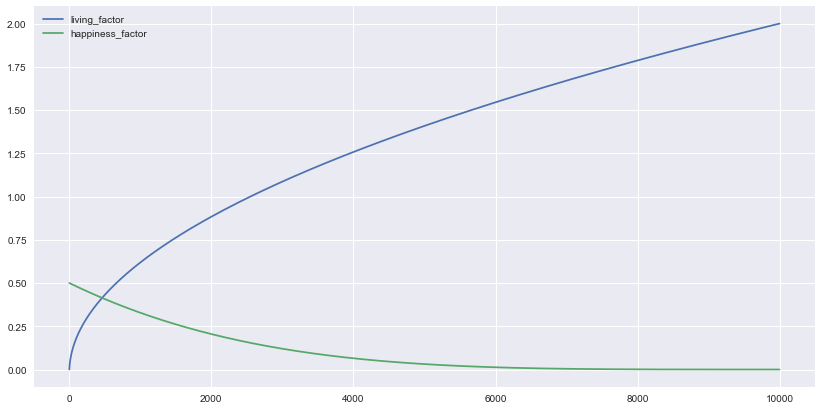

In [20]:
plt.plot(seek_stock.living_factor * seek_stock.living_consume)
plt.plot(seek_stock.happiness_factor * seek_stock.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')

In [7]:
class FameSeekDay(BaseSeekDay):
    """
        FameTask追求名望权力的一天:
        追求名望权力
    """

    def _init_self(self):
        # 每天对生命消耗的常数＝3，即代表3天
        self.living_consume = 3
        # 每天幸福指数常数＝0.6
        self.happiness_base = 0.6
        # 名望权利积累常数＝10，默认＝0
        self.fame_base = 10
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成12000个序列
        days = np.arange(1, 12000)
        # 针对生命消耗living_factor的基础函数还是sqrt
        living_days = np.sqrt(days)
        # 由于不需要像HealthSeekDay从负数开始，所以直接regular_mm 即:0->1
        self.living_factor = regular_mm(living_days)

        # 针对幸福感可变序列使用了np.power2
        # 即变化速度比StockSeekDay慢但比HealthSeekDay快
        happiness_days = np.power(days, 2)
        # 幸福指数可变因素递减由1->0
        self.happiness_factor = regular_mm(happiness_days)[::-1]

        # 这里简单设定fame_factor=living_factor
        self.fame_factor = self.living_factor

In [22]:
# 初始化我, 你一生的故事：FameSeekDay
me = Person()
# 初始化追求名望权力
seek_fame = FameSeekDay()
while me.living > 0:
    # 只要还活着，就追求名望权力
    me.live_one_day(seek_fame)

print('只追求名望权力活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       round(me.wealth, 2), round(me.fame, 2)))

只追求名望权力活了36.06年，幸福指数2400.1, 积累财富0, 名望权力91259.86


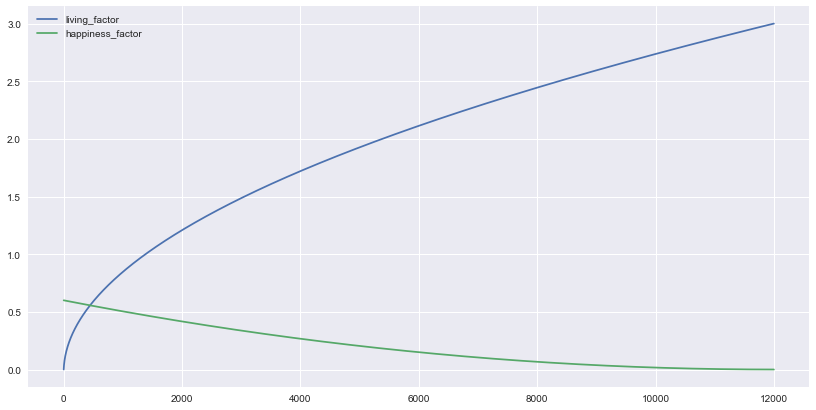

In [24]:
plt.plot(seek_fame.living_factor * seek_fame.living_consume)
plt.plot(seek_fame.happiness_factor * seek_fame.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best');

### 6.2.2 使用蒙特卡洛方法计算怎样度过一生最幸福

In [8]:
def my_life(weights):
    """
        追求健康长寿快乐的权重:weights[0]
        追求财富金钱的权重:weights[1]
        追求名望权力的权重:weights[2]
    """
    # 追求健康长寿快乐
    seek_health = HealthSeekDay()
    # 追求财富金钱
    seek_stock = StockSeekDay()
    # 追求名望权力
    seek_fame = FameSeekDay()

    # 放在一个list中对对应下面np.random.choice中的index[0, 1, 2]
    seek_list = [seek_health, seek_stock, seek_fame]

    # 初始化我
    me = Person()
    # 加权随机抽取序列。80000天肯定够了, 80000天快220年了。。。
    seek_choice = np.random.choice([0, 1, 2], 80000, p=weights)

    while me.living > 0:
        # 追求从加权随机抽取序列已经初始化好的
        seek_ind = seek_choice[me.living_day]
        seek = seek_list[seek_ind]
        # 只要还活着，就追求
        me.live_one_day(seek)
    return round(me.living_day / 365, 2), round(me.happiness, 2), \
        round(me.wealth, 2), round(me.fame, 2)

In [34]:
living_day, happiness, wealth, fame = my_life([0.4, 0.3, 0.3])
print('活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format(
    living_day, happiness, wealth, fame))

活了76.8年，幸福指数9307.38, 积累财富51442.17, 名望权力46466.79


In [35]:
weights = np.random.random(3)
weights /= np.sum(weights)
weights

array([ 0.39509305,  0.0958781 ,  0.50902885])

In [9]:
from abupy import AbuProgress
progress = AbuProgress(2000, 0, label='my_life...')
    
result = []
for _ in xrange(2000):
    # 2000次随机权重分配
    weights = np.random.random(3)
    weights /= np.sum(weights)
    # result中：tuple[0]权重weights,，tuple[1]my_life返回的结果
    result.append((weights, my_life(weights)))
    progress.show()

In [38]:
# result中tuple[1]=my_life返回的结果, my_life[1]=幸福指数，so->x[1][1]
sorted_scores = sorted(result, key=lambda x: x[1][1], reverse=True)
# 将最优权重sorted_scores[0][0]代入my_life得到结果
living_day, happiness, wealth, fame = my_life(sorted_scores[0][0])

print('活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
          (living_day, happiness, wealth, fame))

print('人生最优权重：追求健康{:.3f},追求财富{:.3f},追求名望{:.3f}'.format(
        sorted_scores[0][0][0], sorted_scores[0][0][1],
        sorted_scores[0][0][2])) 

活了76.07年，幸福指数9371.97, 积累财富33129.62, 名望权力56357.91
人生最优权重：追求健康0.427,追求财富0.227,追求名望0.345


[1759.24, 4908.709]     200
(4908.709, 6240.504]    200
(6240.504, 7177.066]    200
(7177.066, 7765.22]     200
(7765.22, 8272.07]      200
(8272.07, 8623.97]      200
(8623.97, 8863.859]     200
(8863.859, 9051.348]    200
(9051.348, 9241.929]    200
(9241.929, 9372.7]      200
dtype: int64


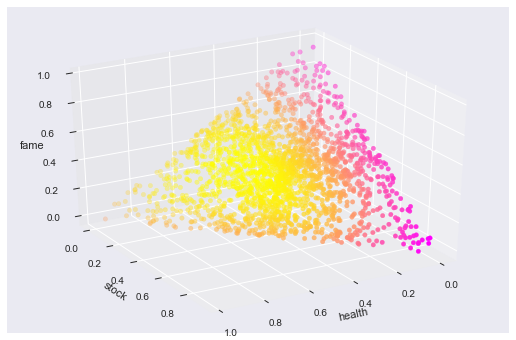

In [10]:
from mpl_toolkits.mplot3d import Axes3D
"""
    result中: tuple[0]权重weights, tuple[1]my_life返回的结果
    r[0][0]: 追求健康长寿快乐的权重
    r[0][1]: 追求财富金钱的权重
    r[0][2]: 追求名望权力的权重
    r[1][1]: my_life[1]=幸福指数
"""
result_show = np.array(
    [[r[0][0], r[0][1], r[0][2], r[1][1]] for r in result])

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
ax.view_init(30, 60)
"""
    x:追求健康长寿快乐的权重, y:追求财富金钱的权重
    z:追求名望权力的权重, c:color 幸福指数, 颜色越深越幸福
"""
ax.scatter3D(result_show[:, 0], result_show[:, 1], result_show[:, 2],
             c=result_show[:, 3], cmap='spring')
ax.set_xlabel('health')
ax.set_ylabel('stock')
ax.set_zlabel('fame')

# 幸福指数
happiness_result = result_show[:, 3]
# 使用qcut分10份
print(pd.qcut(happiness_result, 10).value_counts())

### 6.2.3 凸优化基础概念

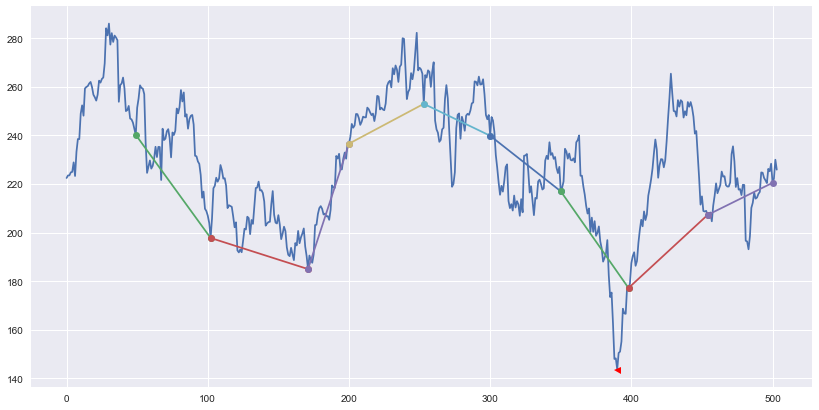

In [40]:
import scipy.optimize as sco
from scipy.interpolate import interp1d

# 继续使用TSLA收盘价格序列
tsla_close = ABuSymbolPd.make_kl_df('usTSLA').close
# x = (0, 1, 2,...,len(tsla_close))
x = np.arange(0, tsla_close.shape[0])
# y= 收盘价格numpy序列
y = tsla_close.values
# interp1d线性插值函数
linear_interp = interp1d(x, y)
# 绘制插值
plt.plot(linear_interp(x))

# fminbound寻找给定范围内的最小值：在linear_inter中寻找全局最优范围1－504
global_min_pos = sco.fminbound(linear_interp, 1, 504)
# 绘制全局最优点，全局最小值点，r<：红色三角
plt.plot(global_min_pos, linear_interp(global_min_pos), 'r<')

# 每个单位都先画一个点，由两个点连成一条直线形成股价骨架图
last_postion = None
# 步长50，每50个单位求一次局部最小
for find_min_pos in np.arange(50, len(x), 50):
    # fmin_bfgs寻找给定值的局部最小值
    local_min_pos = sco.fmin_bfgs(linear_interp, find_min_pos, disp=0)
    # 形成最小点位置信息(x, y)
    draw_postion = (local_min_pos, linear_interp(local_min_pos))
    # 第一个50单位last_postion＝none, 之后都有值
    if last_postion is not None:
        # 将两两临近局部最小值相连，两个点连成一条直线
        plt.plot([last_postion[0][0], draw_postion[0][0]],
                 [last_postion[1][0], draw_postion[1][0]], 'o-')
    # 将这个步长单位内的最小值点赋予last_postion
    last_postion = draw_postion

### 6.2.4 全局最优求解怎样度过一生最幸福

In [41]:
def minimize_happiness_global(weights):
    if np.sum(weights) != 1:
        # 过滤权重和不等于1的权重组合
        return 0
    # 最优都是寻找最小值，所以要得到幸福指数最大的权重，
    # 返回-my_life，这样最小的结果其实是幸福指数最大的权重配比
    return -my_life(weights)[1]

opt_global = sco.brute(minimize_happiness_global,
                       ((0, 1.1, 0.1), (0, 1.1, 0.1), (0, 1.1, 0.1)))
opt_global

array([ 0.5,  0.2,  0.3])

In [42]:
living_day, happiness, wealth, fame = my_life(opt_global)
print('活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (living_day, happiness, wealth, fame))

活了79.88年，幸福指数9343.26, 积累财富28416.16, 名望权力50660.62


### 6.2.5 非凸函数计算怎样度过一生最幸福

In [43]:
method='SLSQP'
# 提供一个函数来规范参数,np.sum(weights) = 1 -> np.sum(weights) - 1 = 0   
constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
# 参数的范围选定
bounds = tuple((0, 1) for x in xrange(3))
print(bounds)


def minimize_happiness_local(weights):
    print(weights)
    return -my_life(weights)[1]

# 初始化猜测最优参数，这里使用brute计算出的全局最优参数作为guess
guess = [0.5, 0.2, 0.3]
opt_local = sco.minimize(minimize_happiness_local, guess,
                         method=method, bounds=bounds,
                         constraints=constraints)
opt_local

((0, 1), (0, 1), (0, 1))
[ 0.5  0.2  0.3]
[ 0.5  0.2  0.3]
[ 0.50000001  0.2         0.3       ]
[ 0.5         0.20000001  0.3       ]
[ 0.5         0.2         0.30000001]


     fun: -9338.1200000000008
     jac: array([  8.58993459e+07,  -2.49644974e+08,  -1.79851756e+08,
         0.00000000e+00])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([ 0.5,  0.2,  0.3])

## 要跑很长时间，下面的图

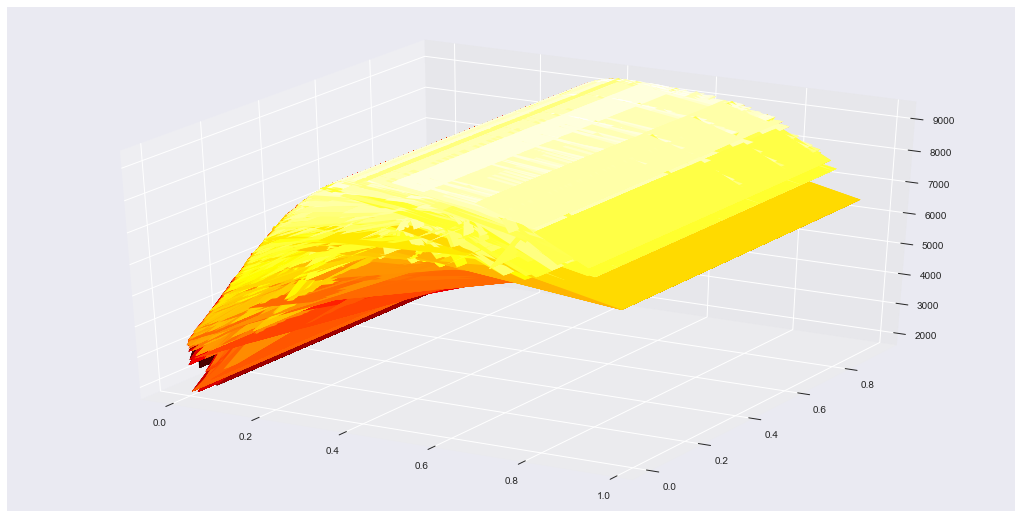

In [11]:
"""
    result中: tuple[0]权重weights, tuple[1]my_life返回的结果
    r[0][0]: 追求健康长寿快乐的权重
    r[0][1]: 追求财富金钱的权重
    r[0][2]: 追求名望权力的权重
    r[1][1]: my_life[1]=幸福指数
"""
result_show = np.array(
    [[r[0][0], r[0][1], r[0][2], r[1][1]] for r in result])

fig = plt.figure()
ax = Axes3D(fig)
x = result_show[:, 0]
y = result_show[:, 1]
# 由于3d可视化这里只使用两个权重维度做为x, y然后做meshgrid
x_grid, y_grid = np.meshgrid(x, y)
# 在meshgrid基础上第三个维度可视化幸福指数
z_grid = result_show[:, 3]
# plot_surface: x, y, z
ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1,
                cmap='hot');

### 6.2.6 标准凸函数求最优

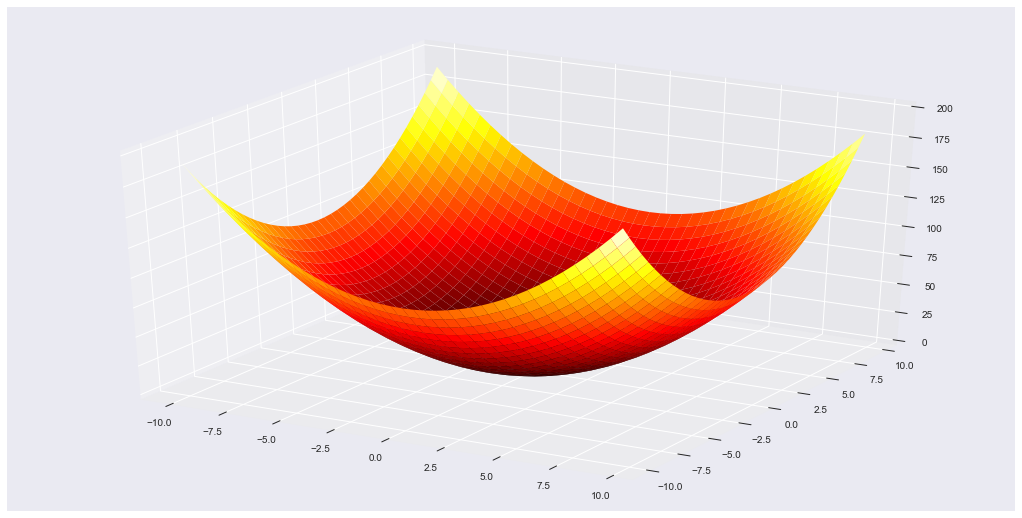

In [44]:
fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
x_grid, y_grid = np.meshgrid(x, y)
# z^2 = x^2 + y^2
z_grid = x_grid ** 2 + y_grid ** 2

ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1,
                cmap='hot')

In [45]:
def convex_func(xy):
    return xy[0] ** 2 + xy[1] ** 2

bounds = ((-10, 10), (-10, 10))
guess = [5, 5]
for method in ['SLSQP', 'TNC', 'L-BFGS-B']:
    # 打印start
    print(method + ' start')
    ret = sco.minimize(convex_func, guess, method=method,
                       bounds=bounds)
    print(ret)
    # 这里通过np.allclose判定结果是不是（0， 0）
    print('result is (0, 0): {}'.format(
        np.allclose(ret['x'], [0., 0.], atol=0.001)))
    # 打印end
    print(method + ' end')

SLSQP start
     fun: 0.0
     jac: array([  1.49011612e-08,   1.49011612e-08,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.,  0.])
result is (0, 0): True
SLSQP end
TNC start
     fun: 1.3671152097425469e-16
     jac: array([  2.65355085e-08,   2.65355085e-08])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 5
     nit: 2
  status: 0
 success: True
       x: array([  8.26775426e-09,   8.26775426e-09])
result is (0, 0): True
TNC end
L-BFGS-B start
      fun: 1.7070610160649634e-15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.84304889e-08,   6.84304889e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 1
   status: 0
  success: True
        x: array([  2.92152444e-08,   2.92152444e-08])
result is (0, 0): True
L-BFGS-B end


## 6.3 线性代数

In [46]:
# 获取多支股票数据组成panel
my_stock_df = ABuSymbolPd.make_kl_df(
    ['usBIDU', 'usGOOG', 'usFB', 'usAAPL', 'us.IXIC'], n_folds=2)
# 变换轴向，形成新的切面
my_stock_df = my_stock_df.swapaxes('items', 'minor')
my_stock_df_close = my_stock_df['close'].dropna(axis=0)
# 表6-2所示
my_stock_df_close.tail()

us.IXIC  usAAPL  usBIDU    usFB  usGOOG
2016-07-20  5089.930   99.96  160.65  121.92  741.19
2016-07-21  5073.900   99.43  161.40  120.61  738.63
2016-07-22  5100.160   98.66  160.88  121.00  742.74
2016-07-25  5097.628   97.34  160.25  121.63  739.77
2016-07-26  5084.629   97.76  163.09  121.64  740.92

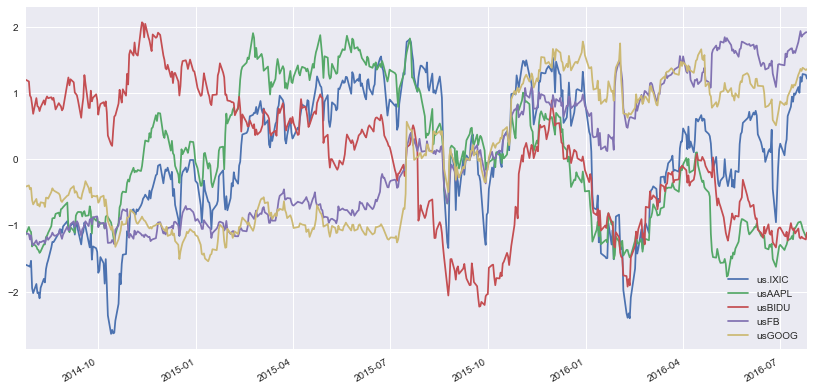

In [47]:
def regular_std(group):
    # z-score规范化也称零-均值规范化
    return (group - group.mean()) / group.std()

my_stock_df_close_std = regular_std(my_stock_df_close)
my_stock_df_close_std.plot()

In [48]:
from scipy import mat, linalg

### 6.3.1 矩阵基础知识

In [49]:
# dataframe转换matrix通过as_matrix
cs_matrix = my_stock_df_close.as_matrix()
# cs_matrix本身有5列数据(5支股票)，要变成方阵即保留5行数据0:5
cs_matrix = cs_matrix[0:5, :]
print(cs_matrix.shape)
cs_matrix

(5, 5)


array([[ 4449.56 ,    97.67 ,   226.5  ,    75.19 ,   589.02 ],
       [ 4444.91 ,    99.02 ,   225.8  ,    74.92 ,   590.6  ],
       [ 4442.7  ,    98.38 ,   220.   ,    73.71 ,   585.61 ],
       [ 4462.9  ,    98.15 ,   219.13 ,    74.677,   587.42 ],
       [ 4369.77 ,    95.6  ,   216.05 ,    72.65 ,   571.6  ]])

In [50]:
eye5 = np.eye(5)
eye5

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [51]:
cs_matrix_inv = linalg.inv(cs_matrix)
print('逆矩阵: cs_matrix_inv')
print(cs_matrix_inv)
# 上面打印cs_matrix_inv输出上并非绝对标准单位矩阵，是对角线值元素接近与1，非对
# 角线元素接近与0的矩阵，需要使用np.allclose来确认结果
print('相乘后的结果是单位矩阵：{}'.format(
    np.allclose(np.dot(cs_matrix, cs_matrix_inv), eye5)))

逆矩阵: cs_matrix_inv
[[ -9.53003102e-04  -9.94227739e-03   1.32619438e-03  -1.06930233e-02
    2.08850769e-02]
 [ -1.21921210e+00   1.34895797e+00  -8.23702632e-01  -4.83129572e-02
    7.56113063e-01]
 [  4.50912801e-02   5.73883374e-02   3.53113179e-03  -2.35567697e-01
    1.32708349e-01]
 [ -7.78016826e-01   1.18199410e+00  -1.95638102e+00   9.17562402e-01
    6.41818646e-01]
 [  2.93040644e-01  -3.21528233e-01   3.74945744e-01   6.22432880e-02
   -4.16107689e-01]]
相乘后的结果是单位矩阵：True


### 6.3.2 特征值和特征向量

In [52]:
a = mat('[1.5 -0.5; -0.5 1.5]')
u, d = linalg.eig(a)
print('特征值向量：{}'.format(u))
print('特征向量（列向量）矩阵：{}'.format(d)) 

特征值向量：[ 2.+0.j  1.+0.j]
特征向量（列向量）矩阵：[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]



### 6.3.4 PCA和SVD使用实例

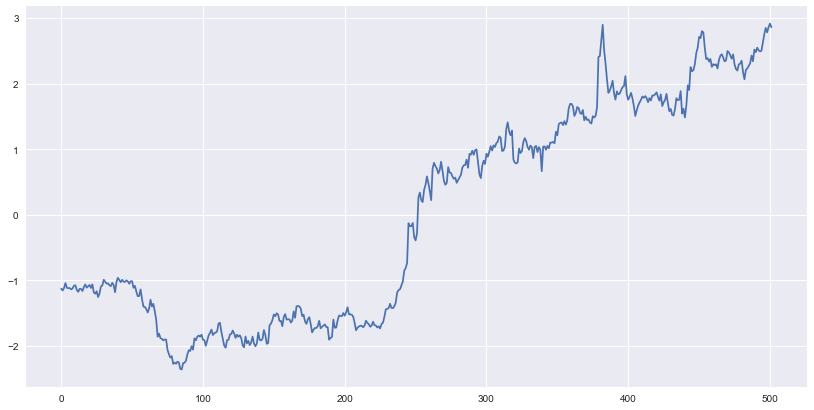

In [53]:
from sklearn.decomposition import PCA

# n_components=1只保留一个维度
pca = PCA(n_components=1)
# 稍后会有展示fit_transform的实现，以及关键核心代码抽取
my_stock_df_trans_pca = \
    pca.fit_transform(my_stock_df_close_std.as_matrix())

plt.plot(my_stock_df_trans_pca)

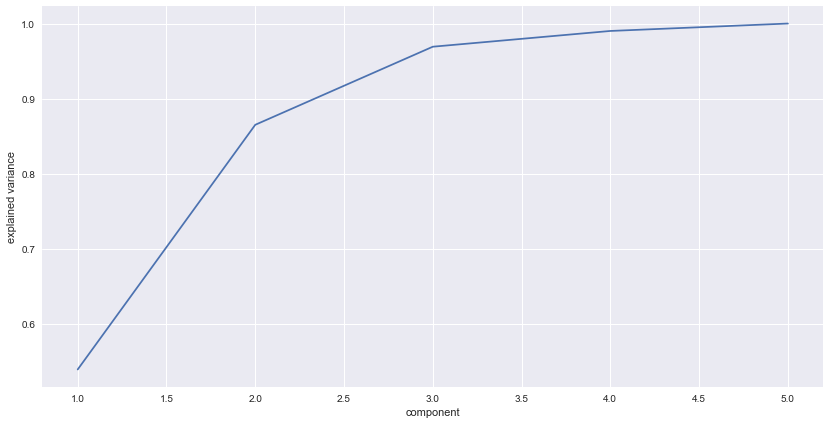

In [54]:
# 可视化维度和主成分关系，参数空
pca = PCA()
# 直接使用fit，不用fit_transform
pca.fit(my_stock_df_close_std)

# x:保留的维度 y:保留的维度下的方差比总和即保留了多少主成分
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('component')
plt.ylabel('explained variance')

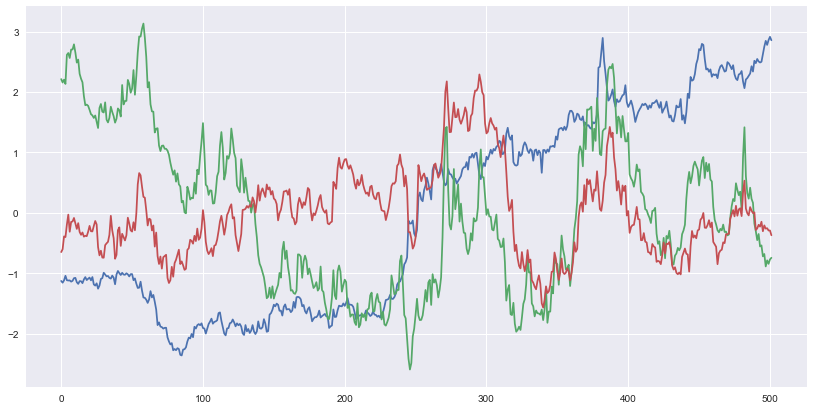

In [56]:
# 0.95即保留95%主成分
pca = PCA(0.95)
# 稍后会有展示fit_transform的实现，以及关键核心代码抽取
my_stock_df_trans_pca = \
    pca.fit_transform(my_stock_df_close_std.as_matrix())
plt.plot(my_stock_df_trans_pca);

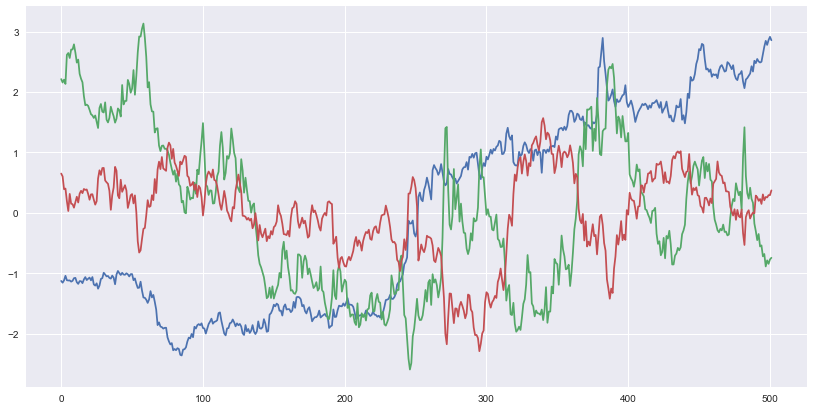

In [57]:
def my_pca(n_components=1):
    # svd奇异值分解
    U, S, V = linalg.svd(my_stock_df_close_std.as_matrix(),
                         full_matrices=False)
    # 通过n_components进行降维
    U = U[:, :n_components]
    U *= S[:n_components]
    # 绘制降维后的矩阵
    plt.plot(U)
# 输出如图6－19所示
my_pca(n_components=3)